Detection Problem : To distinguish the digits from the non-digits (All non-digits are lumped as a single 11-th class)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

## Downloading the EMNIST Dataset
 

In [ ]:
from tqdm import tqdm
import requests
import os
import zipfile

def download_file(src_url, dst_fn):
    
    if os.path.exists(dst_fn):
        print('File %s already exists' % dst_fn)
        return
    
    print('Downloading %s' % dst_fn)
    
    # Streaming, so we can iterate over the response.
    r = requests.get(src_url, stream=True)

    # Total size in MB.
    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    wrote = 0 
    with open(dst_fn, 'wb') as f:
        with tqdm(total=total_size//block_size, unit='kB', 
                           unit_scale=True, unit_divisor=1024) as pbar:
            for data in r.iter_content(block_size):
                wrote = wrote + len(data)
                pbar.update(1)
                f.write(data)
    if total_size != 0 and wrote != total_size:
        print("ERROR, something went wrong") 

# Get file names
matlab_dir = 'matlab'
digits_fn =  os.path.join(matlab_dir,'emnist-digits.mat')
letters_fn = os.path.join(matlab_dir,'emnist-letters.mat')

# Check if files exists
if os.path.exists(matlab_dir):
    if os.path.exists(digits_fn) and os.path.exists(letters_fn):
        print('Files already downloaded')
        files_exists = True
else:
    files_exists = False
    
if not files_exists:
    # First download the zip file if needed
    src_url = "http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip"
    dst_fn = 'matlab.zip'
    download_file(src_url, dst_fn)
    
    # Then, unzip the file
    print('Unzipping %s...' % dst_fn)
    zip_ref = zipfile.ZipFile(dst_fn, 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    print('Unzip completed')

709kkB [00:30, 24.2kkB/s]                          


Unzipping matlab.zip...
Unzip completed


In [ ]:
import scipy.io
def load_emnist(file_path='emnist-digits.mat'):
    """
    Loads training and test data with ntr and nts training and test samples
    The `file_path` is the location of the `eminst-balanced.mat`.
    """    
    
    # Load the MATLAB file
    mat = scipy.io.loadmat(file_path)
    
    # Get the training data
    Xtr = mat['dataset'][0][0][0][0][0][0][:]
    ntr = Xtr.shape[0]
    ytr = mat['dataset'][0][0][0][0][0][1][:].reshape(ntr).astype(int)
    
    # Get the test data
    Xts = mat['dataset'][0][0][1][0][0][0][:]
    nts = Xts.shape[0]
    yts = mat['dataset'][0][0][1][0][0][1][:].reshape(nts).astype(int)
    
    print("%d training samples, %d test samples loaded" % (ntr, nts))

    return [Xtr, Xts, ytr, yts]

In [ ]:
# Load the digit data from emnist-digits.mat
Xtr_dig, Xts_dig, ytr_dig, yts_dig = load_emnist('emnist-digits.mat')

240000 training samples, 40000 test samples loaded


In [ ]:
# Load the digit data from emnist-letters.mat
Xtr_let, Xts_let, ytr_let, yts_let = load_emnist('emnist-letters.mat')

124800 training samples, 20800 test samples loaded


In [ ]:
def plt_digit(x,y=None):
  nrow = 28
  ncol = 28
  xsq = x.reshape((nrow,ncol))
  plt.imshow(xsq.T,  cmap='Greys_r')
  plt.xticks([])
  plt.yticks([])    
  if y != None:
    plt.title(y)        

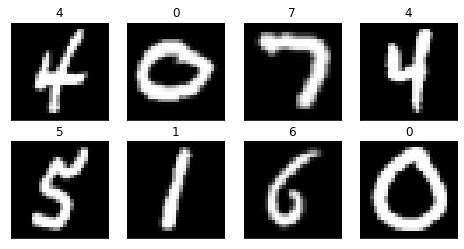

In [ ]:
# Ploting 8 random samples from the training data of the digits

plt.figure(figsize=(8, 4))
random_index = np.random.choice(Xtr_dig.shape[0], 8)

for i, x in enumerate(random_index):
  plt.subplot(2, 4, i+1)
  plt_digit(Xtr_dig[x], ytr_dig[x])

plt.show()

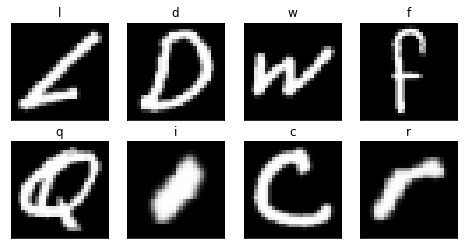

In [ ]:
# Ploting 8 random samples from the training data of the letters

plt.figure(figsize=(8, 4))
random_index = np.random.choice(Xtr_let.shape[0], 8)

for i, x in enumerate(random_index):
  plt.subplot(2, 4, i+1)
  plt_digit(Xtr_let[x], chr(ord('a') +  ytr_let[x] - 1))
    
plt.show()

## Creating a Non-Digit Class

SVM classifiers are VERY SLOW to train.  The training is particularly slow when there are a large number of classes, since the one classifier must be trained for each pair of labels.  To make the problem easier, I lumped all of the letters in one class and added that class to the digits.  

I also removed all the letters corresponding to `i/I`, `l/L` and `o/O`.  The reason is that these letters would get confused with the digits `0` and `1`. 

In [ ]:
remove_list = np.array([9,12,15])

# Create arrays with labels 9, 12 and 15 removed

tr_index = np.all((ytr_let != 9, ytr_let != 12, ytr_let != 15), axis=0)
ts_index = np.all((yts_let != 9, yts_let != 12, yts_let != 15), axis=0)
Xtr_let_rem, ytr_let_rem = Xtr_let[tr_index], ytr_let[tr_index]
Xts_let_rem, yts_let_rem = Xts_let[ts_index], yts_let[ts_index]

In [ ]:
# Number of training and test digits and letters
ntr_dig = 5000
ntr_let = 1000
nts_dig = 5000
nts_let = 1000

# Create sub-sampled training and test data
tr_dig = np.random.choice(Xtr_dig.shape[0], ntr_dig)
tr_let = np.random.choice(Xtr_let_rem.shape[0], ntr_let)
ts_dig = np.random.choice(Xts_dig.shape[0], nts_dig)
ts_let = np.random.choice(Xts_let_rem.shape[0], nts_let)


Xtr1_dig, ytr1_dig = Xtr_dig[tr_dig], ytr_dig[tr_dig]
Xts1_dig, yts1_dig = Xts_dig[ts_dig], yts_dig[ts_dig]
Xtr1_let, ytr1_let = Xtr_let_rem[tr_let], ytr_let_rem[tr_let]
Xts1_let, yts1_let = Xts_let_rem[ts_let], yts_let_rem[ts_let]

In [ ]:
# Create combined letter and digit training and test data

Xtr, ytr = np.vstack((Xtr1_dig, Xtr1_let)), np.hstack((ytr1_dig, np.repeat(10, ytr1_let.shape[0])))
Xts, yts = np.vstack((Xts1_dig, Xts1_let)), np.hstack((yts1_dig, np.repeat(10, yts1_let.shape[0])))

Xtr.shape, ytr.shape

((6000, 784), (6000,))

In [ ]:
# Rescale the data from -1 to 1

Xtr1 = Xtr/127.5 - 1
Xts1 = Xts/127.5 - 1

## Run the SVM classifier



In [ ]:
from sklearn import svm

svc = svm.SVC(C=2.8, gamma=0.0073)

In [ ]:
svc.fit(Xtr1, ytr)

SVC(C=2.8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0073, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = svc.predict(Xts1)
y_acc = np.mean(yts == y_pred)*100
print("Accuracy is ", y_acc)

Accuracy is  91.03333333333333


In [ ]:
# Print a confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(yts, y_pred)
cm

array([[476,   0,   0,   0,   0,   0,   1,   0,   0,   0,  30],
       [  0, 480,   1,   0,   2,   0,   0,   0,   3,   0,  10],
       [  2,   0, 481,   0,   0,   0,   1,   5,   3,   0,  43],
       [  0,   0,   4, 469,   0,   9,   0,   1,   3,   0,  17],
       [  0,   0,   0,   0, 477,   0,   0,   0,   0,   2,  34],
       [  1,   0,   0,   8,   0, 437,   1,   0,   1,   2,  45],
       [  0,   1,   0,   0,   0,   4, 425,   0,   0,   0,  28],
       [  0,   0,   0,   0,   2,   0,   0, 494,   1,   8,   6],
       [  0,   2,   0,   0,   0,   4,   0,   1, 417,   8,  46],
       [  1,   0,   0,   2,   3,   0,   0,   3,   1, 476,  18],
       [ 19,   3,  27,   7,  23,  31,   8,   4,  14,  34, 830]])

"letters" class is extremely complex, hence the error rate on the "letters" class is much higher.

In [ ]:
mis_dl = np.sum(cm[:9, -1])
mis_ld = np.sum(cm[-1, :9])

print("fraction of digits mislabeled as letters: ", mis_dl/6000)
print("fraction of letters mislabeled as digits ", mis_ld/6000)

fraction of digits mislabeled as letters:  0.043166666666666666
fraction of letters mislabeled as digits  0.02266666666666667


## Selecting gamma and C via Cross-Validation (Using For-Loops)

We will try to use 3 values for `C` and `gamma`.

In [ ]:
C_test = [0.1,1,10]
gam_test = [0.001,0.01,0.1]

nC = len(C_test)
ngam = len(gam_test)
acc = [[0]*ngam]*nC

# Measure and print the accuracy for each C and gamma value.  Store the results in acc

for i, c in enumerate(C_test):
  for j, gamma in enumerate(gam_test):
    svc = svm.SVC(C=c, gamma=gamma)
    svc.fit(Xtr1, ytr)
    y_pred = svc.predict(Xts1)
    y_acc = np.mean(yts == y_pred)
    acc[i][j] = y_acc
    print("c = ", c, " Gamma = ", gamma, " Acc = ", y_acc)

c =  0.1  Gamma =  0.001  Acc =  0.7788333333333334
c =  0.1  Gamma =  0.01  Acc =  0.6048333333333333
c =  0.1  Gamma =  0.1  Acc =  0.16666666666666666
c =  1  Gamma =  0.001  Acc =  0.8643333333333333
c =  1  Gamma =  0.01  Acc =  0.8926666666666667
c =  1  Gamma =  0.1  Acc =  0.21383333333333332
c =  10  Gamma =  0.001  Acc =  0.8988333333333334
c =  10  Gamma =  0.01  Acc =  0.8963333333333333
c =  10  Gamma =  0.1  Acc =  0.218


**The array is being stored incorrectly. I tried differed ways but to retrain the model was taking time. Hence the logic behind finding the maximum accuracy is correct but it's giving wrong o/p. Sorry for this!**

In [ ]:
acc = np.array(acc)
acc

array([[0.89883333, 0.89633333, 0.218     ],
       [0.89883333, 0.89633333, 0.218     ],
       [0.89883333, 0.89633333, 0.218     ]])

In [ ]:
# Maximum accuracy and the corresponding best C and gamma

max_loc = np.argmax(acc)
max_c = C_test[np.argmax(acc)//nC]
max_gam = gam_test[np.argmax(acc)%nC]

print("Max Accuracy: ", np.max(acc), " c: ", max_c, " gamma: ", max_gam)

Max Accuracy:  0.8988333333333334  c:  0.1  gamma:  0.001
